To get more efficient algorithm for solving the game we need to better identify when a ship has been sunk. Thankfully, the official rules of the game help us in this regard. Up until now, we have only used two states for giving feedback on each shot: **HIT** and **MISS**.

The official rules of the game also state that you should let your opponent know if they have successfully **SUNK** any ship, so this third style message "*You have sunk my aircraft carrier*" conveys much more information than just hit.

It tells you the length of the ship you have just hit, it tells you that you have hit all pixels of this ship, and it could, potentially, give you a new minimum size of ship you are searching for (for instance, if you have sunk all ships other than the aircraft carrier, then you know that this remaining ship is five units long and can adjust your random search according to skip the appropriate number of spaced when in hunt mode.

First thing to implement is adding some way of knowing if ship is sunk. Currently, there's no notion of a ship. Gameboard just draws squares on passed locations. We'll try to do this without completely rewriting existing classes. For that, we make a Ship class. But we add generate_separate_locations method to Random class first. That method will help us initialize ship objects.

In [1]:
import random as pyrandom
from Gameboard import *

In [2]:
class Random:
    def __init__(self):
        # possible locations list isn't affected by the methods
        self.possible_locations = []
        self.available_locations = []
        for i in Gameboard.row_labels:
            for j in Gameboard.col_labels:
                self.possible_locations.append(i + str(j))
                self.available_locations.append(i + str(j))
        
    def reset_available_locations(self):
        self.available_locations = self.possible_locations.copy()
        
    # chooses random location from available locations list and removes it if keep is False
    def choose(self, keep=False):
        choice = pyrandom.choice(self.available_locations)
        if not keep:
            self.available_locations.remove(choice)
        return choice
    
    # returns random location from possible locations list
    def choose_from_all(self):
        return pyrandom.choice(self.possible_locations)
    
    # removes passed location from available locations list 
    def make_unavailable(self, location):
        self.available_locations.remove(location)
    
    # generates random locations for ships of various length and returns them
    # WARGING: current implementation is not optimal and should be changed sometime in the future
    # NOTE: this method currently uses choose method but it resets available locations at the end
    def generate_ship_locations(self, lengths=[5, 4, 3, 3, 2]):
        flat_list = []
        for sublist in self.generate_separate_locations(lengths):
            for item in sublist:
                flat_list.append(item)
        return flat_list
    
    # returns array of ship locations, where ship locations are array of locations themselves
    # for example: [2, 3] returns [['A1', 'A2'], ['C3', 'C4', 'C5']]
    def generate_separate_locations(self, lengths=[5, 4, 3, 3, 2]):
        locations = []
        
        for length in lengths:
            orientation = pyrandom.choice(['horizontal', 'vertical'])
            
            # randomize a ship location until it fits
            while True:
                choice_pivot = self.choose(keep=True)
                choices = [choice_pivot]
                if orientation == 'horizontal':   
                    # generate all other choices (for horizontal orientation)
                    for i in range(length - 1):
                        # when orientation is horizontal, column is changed
                        choice_next = choice_pivot[0] + str(int(choice_pivot[1:]) + i + 1)
                        choices.append(choice_next)
                else:
                    # generate all other choices (for vertical orientation)
                    for i in range(length - 1):
                        # when orientation is vertical, row is changed
                        choice_next = chr(ord(choice_pivot[0]) + i + 1) + choice_pivot[1:]
                        choices.append(choice_next)
                # after generation, we must check if locations are legal
                is_legal = True
                for choice in choices:
                    if choice not in self.available_locations:
                        is_legal = False
                # if they're legal, we update available locations and break the loop
                if is_legal:
                    self.available_locations = [x for x in self.available_locations if x not in choices]
                    locations.append(choices)
                    break
        
        # reset available locations and return result
        self.reset_available_locations()
        return locations

In [3]:
# test newly added method
random = Random()
random.generate_separate_locations()

[['E3', 'E4', 'E5', 'E6', 'E7'],
 ['G2', 'H2', 'I2', 'J2'],
 ['F2', 'F3', 'F4'],
 ['E9', 'F9', 'G9'],
 ['G4', 'H4']]

In [4]:
class Ship:
    # Random class already can generate locations, so we can initialize ship after that
    def __init__(self, locations):
        self.locations = locations
        self.length = len(locations)
        self.destroyed_locations = set()
        self.is_damaged = False
        
    def get_length(self):
        return self.length
    
    def get_locations(self):
        return self.locations
    
    def destroy(self, location):
        self.is_damaged = True
        self.destroyed_locations.add(location)
        
    # returns True if at least one cell is hit
    def is_damaged():
        return self.is_damaged
        
    def is_sunk(self):
        return len(self.destroyed_locations) == self.length

In [5]:
# test Ship class
ship = Ship(random.generate_separate_locations()[0])
print(ship.get_locations())
print(ship.get_length())
print(ship.is_sunk())
for loc in ship.get_locations():
    ship.destroy(loc)
print(ship.is_sunk())

['A7', 'B7', 'C7', 'D7', 'E7']
5
False
True


Now that we will be told when a ship is sunk, we know which ships (and even more importantly what the lengths of the ships) are still active. These facts are very valuable in determining which location we search next.

Our new algorithm will calculate the most probably location to fire at next based on a superposition of all possible locations the enemy ships could be in.

At the start of every new turn, based on the ships still left in the battle, we’ll work out all possible locations that every ship could fit (horizontally or vertically).

Initially, this will be pretty much anywhere, but as more and more shots are fired, some locations become less likely, and some impossible. Every time it’s possible for a ship to be placed in over a grid location, we’ll increment a counter for that cell. The result will be a superposition of probabilities. ![PDF](https://i.imgur.com/GLmCEui.png)

In the following simple examples, we're just looking at the probabilities for the location of an aircraft carrier (length 5 units). We start in the top left corner, and try placing it horizontally. If it fits, we increment a value for each cell it lays over as a 'possible location' in which there could a ship. Then we try sliding it over one square and repeating ... and so on until we reach the end of the row. Then we move down a line and repeat. Next we repeat the exercise with the ship oriented vertically.

Sometimes the ship will fit a space, sometimes it will not. As the board becomes more and more congested (with hits, misses and sunk ships), the number of possible positions the ships can fit reduces. It's not the absolute number, however, we're looking for. We're simply looking for the most likely location for a ship to be located in based on the information we already know.

Whilst the examples below show just the probablity distributions for where an aircraft carrier could be hidden, for the full implementation we iterate through each not-yet-sunk ship adding them together to create the superposition. The algorithm selects the location with the highest count of possible ships that could be positioned through that square.

In this configuration we can see a white square just to the left of the top miss. It is *impossible* for the aircraft carrier to pass through this square.

![Example 2](https://i.imgur.com/PZVDR8e.png)

A ficticious board layout with lots of misses marked. Many of the locations are *impossible* to host the carrier. The darker the shading, the more possible ways that the carrier could use this square.

![Example 3](https://i.imgur.com/jpUAzzx.png)

This algorithm still has a **hunt** mode and **target** mode, though both operate essentially the same way. When in hunt mode, there are only three states to worry about: *unvisited space, misses* and *sunk ships*. Misses and Sunk ships are treated the same (obstructions that potential ships needed to be placed around). In target mode (where there is at least one hit ship that has not been sunk), then ships can, by definition, pass through this location, and so hit squares are treated as *unvisited space* squares for deciding if a ship 'could' pass through this square, and then a **heavy** score weighting is granted to possible locations that pass through a point we know already know contains a hit.

If we want to implement everything that's written above, first we must add functionality to gameboard which helps us draw probability distribution. For that, we change last 3 methods in Gameboard class. Also, we add set_probabilities function. Everything else stays the same.

In [6]:
class Gameboard:
    # static variables (they aren't intended to change)
    nrows, ncols = 10, 10
    col_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    row_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    boat_color = colors.to_rgb('royalblue')
    hit_color = colors.to_rgb('red')
    
    def __init__(self):
        # create board image (initially completely white)
        self.board = np.ones([Gameboard.nrows, Gameboard.ncols, 3])
        # create marker locations array
        self.markers = []

        # create figure and axes
        self.fig, self.ax = plt.subplots()

        # show all ticks
        self.ax.set_xticks(np.arange(Gameboard.ncols))
        self.ax.set_yticks(np.arange(Gameboard.nrows))

        # set custom labels
        self.ax.set_xticklabels(Gameboard.col_labels)
        self.ax.set_yticklabels(Gameboard.row_labels)
        
        # set up minor ticks
        self.ax.minorticks_on()
        self.ax.set_xticks(np.arange(Gameboard.ncols) + 0.5, minor=True)
        self.ax.set_yticks(np.arange(Gameboard.nrows) + 0.5, minor=True)

        # turn off the display of all ticks
        self.ax.tick_params(which='both', top=False, left=False, right=False, bottom=False)

        # show grid on minor ticks
        self.ax.grid(which='minor', linestyle='-', color='black')

        # set bounds
        self.ax.set_xbound(-0.5, 9.5)
        self.ax.set_ybound(-0.5, 9.5)
        
        # initialize counters
        self.alive_boat_count = 0
        self.shot_count = 0
        self.hit_count = 0
        
    # position should be a string or list of strings in [A-J][1-10] format
    def hide_ship(self, *locations):
        for location in locations:
            self.alive_boat_count += 1
            row = ord(location[0]) - ord('A')
            col = int(location[1:]) - 1
            self.board[row, col] = Gameboard.boat_color
            
    def unhide_ship(self, *locations):
        for location in locations:
            self.alive_boat_count -= 1
            row = ord(location[0]) - ord('A')
            col = int(location[1:]) - 1
            # change square color to white
            self.board[row, col] = 1
    
    def clear(self):
        self.alive_boat_count = 0
        self.shot_count = 0
        self.hit_count = 0
        self.board = np.ones([Gameboard.nrows, Gameboard.ncols, 3])
        self.markers = []
        # removes markers from axes
        self.ax.lines = []
        
    # updates gameboard and returns True if boat was hit
    def shoot(self, location):
        self.shot_count += 1
        
        row = ord(location[0]) - ord('A')
        col = int(location[1:]) - 1

        # store hit marker location
        self.markers.append([col, row])

        # check if boat's at current location and change the color of square to red (destroy ship) if so
        if (self.board[row, col] == Gameboard.boat_color).all():
            self.board[row, col] = Gameboard.hit_color
            self.alive_boat_count -= 1
            self.hit_count += 1
            return True
        else:
            return False
        
    # returns array of neighbouring locations of passed location (diagonal direction doesn't count)
    def neighbours(self, location):
        result = []

        up = chr(ord(location[0]) - 1) + location[1:]
        if self.in_range(up):
            result.append(up)

        down = chr(ord(location[0]) + 1) + location[1:]
        if self.in_range(down):
            result.append(down)

        left = location[0] + str(int(location[1:]) - 1)
        if self.in_range(left):
            result.append(left)

        right = location[0] + str(int(location[1:]) + 1)
        if self.in_range(right):
            result.append(right)

        return result
    
    # returns True if passed location is within bounds
    def in_range(self, location):
        row = ord(location[0]) - ord('A')
        col = int(location[1:]) - 1
        if row >= 0 and row < Gameboard.nrows and col >= 0 and col < Gameboard.ncols:
            return True
        return False
        
    # returns True if all ships are destroyed
    def is_game_over(self):
        if self.alive_boat_count == 0:
            return True
        return False
    
    # returns number of boats currently alive
    def get_alive_count(self):
        return self.alive_boat_count
    
    # returns how many shots have been made so far
    def get_shot_count(self):
        return self.shot_count
    
    # returns how many ships are hit
    def get_hit_count(self):
        return self.hit_count
    
    # returns accuracy (# of hits) / (# of shots)
    def get_accuracy(self):
        if self.shot_count == 0:
            return 0
        else:
            return self.hit_count / self.shot_count
        
    # returns matplotlib figure (if pdf is True, probability matrix is drawn)
    def get_figure(self, pdf=False):
        self.update(pdf=pdf)
        return self.fig
    
    # returns matplotlib axes (if pdf is True, probability matrix is drawn)
    def get_axes(self, pdf=False):
        self.update(pdf=pdf)
        return self.ax
    
    # applies changes made to board (if pdf is True, probability matrix is drawn)
    def update(self, pdf=False):
        for m in self.markers:
            self.ax.plot(m[0], m[1], marker='X', markersize=15, color='darkgray')
        if pdf:
            self.ax.imshow(self.probabilities, origin='upper', cmap='binary',
                           vmin=0, vmax=self.probabilities.max())
        else:
            self.ax.imshow(self.board, origin='upper')
            
    def set_probabilities(self, new):
        self.probabilities = new

In [7]:
%%capture
board = Gameboard()
random = Random()
board.hide_ship(*random.generate_ship_locations())

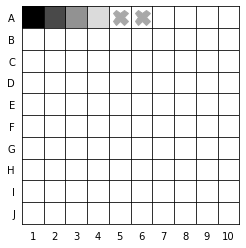

In [8]:
# test updated Gameboard class
probabilities = np.zeros([Gameboard.nrows, Gameboard.ncols])
probabilities[0][0] = 0.7
probabilities[0][1] = 0.5
probabilities[0][2] = 0.3
probabilities[0][3] = 0.1
board.shoot('A5')
board.shoot('A6')
board.set_probabilities(probabilities)
board.get_figure(pdf=True)

Next, we try drawing probability distribution for clean board (no shots are made yet). 

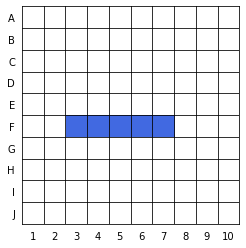

In [9]:
board.clear()
probabilities = np.zeros([Gameboard.nrows, Gameboard.ncols])
ship = Ship(['F3', 'F4', 'F5', 'F6', 'F7'])
board.hide_ship(*ship.get_locations())
board.get_figure()

In [10]:
def get_initial_probabilities(ships):  
    probabilities = []

    for ship in ships:
        probability_mat = np.zeros([Gameboard.nrows, Gameboard.ncols])
        # number of loops required to slide ship across the whole board before changing orientation
        n_loops = Gameboard.nrows * Gameboard.ncols - Gameboard.ncols * (ship.get_length() - 1)

        # this is the loop for vertical orientation
        start_pos = (ship.get_length() - 1, 0)
        for i in range(n_loops):
            curr_row = start_pos[0] + i // Gameboard.ncols
            curr_col = start_pos[1] + i % Gameboard.ncols
            # for horizontal orientations, row stays the same
            base_location = (curr_row, curr_col)
            for j in range(ship.get_length()):
                probability_mat[base_location[0] - j, base_location[1]] += 1

        # reset start_pos for horizontal orientation
        start_pos = (0, 0)
        for i in range(n_loops):
            curr_row = start_pos[0] + i // (Gameboard.ncols - ship.get_length() + 1)
            curr_col = start_pos[1] + i % (Gameboard.ncols - ship.get_length() + 1)
            # for horizontal orientations, row stays the same
            base_location = (curr_row, curr_col)
            for j in range(ship.get_length()):
                probability_mat[base_location[0], base_location[1] + j] += 1
        
        probabilities.append(probability_mat)
        
    return probabilities

In [11]:
def superposition(probabilities):
    result = probabilities[0]
    for i in range(len(probabilities) - 1):
        result = np.add(result, probabilities[i + 1])
    return result

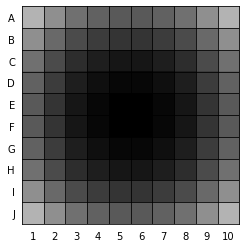

In [12]:
# clear previous mess (if any)
board.clear()
random.reset_available_locations()

# create ships
ships = []
custom_locations = [['A10', 'B10', 'C10', 'D10', 'E10'],
                    ['F4', 'F5', 'F6', 'F7'],
                    ['E2', 'E3', 'E4'], 
                    ['D7', 'D8', 'D9'], 
                    ['J6', 'J7'],]
#random_locations = random.generate_separate_locations()
for shiplocs in custom_locations:
    ships.append(Ship(shiplocs))
    board.hide_ship(*shiplocs)
    
# create required sets
obstacle_locations = set()
hit_locations = set()
prev_obstacles = set()
prev_hits = set()

# create initial probabilities
probabilities = get_initial_probabilities(ships)
board.set_probabilities(superposition(probabilities))
board.get_figure(pdf=True)

In [18]:
%%time
# choose most probable location and shoot
max_loc = np.unravel_index(np.argmax(superposition(probabilities)), (Gameboard.nrows, Gameboard.ncols))
max_loc_str = Gameboard.row_labels[max_loc[0]] + str(Gameboard.col_labels[max_loc[1]])
is_successful = board.shoot(max_loc_str)

# update sets
if is_successful:
    sunk_ship = None
    sunk_ship_index = -1
    for ship_index in range(len(ships)):
        ship = ships[ship_index]
        if max_loc_str in ship.get_locations():
            ship.destroy(max_loc_str)
            if ship.is_sunk():
                sunk_ship = ship
                sunk_ship_index = ship_index
                break

    if sunk_ship is not None:
        prev_hits.add(max_loc)
        for loc in sunk_ship.get_locations():
            loc = (ord(loc[0]) - ord('A'), int(loc[1:]) - 1)
            prev_obstacles.add(loc)
            obstacle_locations.add(loc)
            if loc in hit_locations:
                hit_locations.remove(loc)
            # if ship' sunk, its corresponding probability matrix becomes zero
            probabilities[sunk_ship_index] = np.zeros([Gameboard.nrows, Gameboard.ncols])
    else:
        prev_hits.add(max_loc)
        hit_locations.add(max_loc)
else:
    prev_obstacles.add(max_loc)
    obstacle_locations.add(max_loc)

# if previous shot was a miss
if len(prev_obstacles) == 1:
    (location, ) = prev_obstacles
    
    # we only need to search through location's row and column, since any ship 
    # that did fit previously, still fits if it isn't on the same row/col
    
    for ship_index in range(len(ships)):
        ship = ships[ship_index]
        if ship.is_sunk():
            continue
        
        # this is the loop for horizontal orientation
        n_loops = Gameboard.ncols - ship.get_length() + 1
        curr_row = location[0]
        for i in range(n_loops):
            curr_col = i
            base_location = (curr_row, curr_col)
            curr_locations = []
            for j in range(ship.get_length()):
                loc = (base_location[0], base_location[1] + j)
                curr_locations.append(loc)

            overlaps = False
            for loc in curr_locations:
                if loc == location:
                    overlaps = True
            
            if overlaps:
                for loc in curr_locations:
                    probabilities[ship_index][loc[0], loc[1]] -= 1
                            
        # this is the loop for vertical orientation
        n_loops = Gameboard.nrows - ship.get_length() + 1
        curr_col = location[1]
        for i in range(n_loops):
            curr_row = ship.get_length() - 1 + i
            base_location = (curr_row, curr_col)
            curr_locations = []
            for j in range(ship.get_length()):
                loc = (base_location[0] - j, base_location[1])
                curr_locations.append(loc)
            
            overlaps = False
            for loc in curr_locations:
                if loc == location:
                    overlaps = True
            
            if overlaps:
                for loc in curr_locations:
                    probabilities[ship_index][loc[0], loc[1]] -= 1
    
# if previous shot sunk a ship
elif len(prev_obstacles) > 1:
    # this is a bit complicated. we need to visit affected rows and cols
    # and undo heavy scores. 
    (location, ) = prev_hits
    
    # we save ship orientation because we should ignore 
    # a new obstacle location each time we visit a ship axis
    ship_orientation = 'vertical'
    first_obst = obstacle_locations.pop()
    second_obst = obstacle_locations.pop()
    if first_obst[0] == second_obst[0]:
        ship_orientation = 'horizontal'
    obstacle_locations.add(first_obst)
    obstacle_locations.add(second_obst)
    
    for ship_index in range(len(ships)):
        ship_axis_visited = False
        
        ship = ships[ship_index]
        if ship.is_sunk():
            continue
        
        for pos in prev_obstacles:
            # this is the loop for horizontal orientation
            n_loops = Gameboard.ncols - ship.get_length() + 1
            curr_row = pos[0]
            for i in range(n_loops):
                curr_col = i
                base_location = (curr_row, curr_col)
                curr_locations = []
                for j in range(ship.get_length()):
                    loc = (base_location[0], base_location[1] + j)
                    curr_locations.append(loc)
                
                #print('current locations:', curr_locations)
                
                overlaps = False
                overlaps_ship_ax = False
                should_continue = False
                for loc in curr_locations:
                    if loc not in prev_obstacles and loc in obstacle_locations:
                        should_continue = True
                        break
                    if loc == pos:
                        overlaps = True
                    if loc in prev_obstacles:
                        overlaps_ship_ax = True
                            
                if should_continue:
                    continue

                for loc in curr_locations:
                    if overlaps and pos != location:
                        probabilities[ship_index][loc[0], loc[1]] -= 30
                    if ship_orientation != 'horizontal':
                        probabilities[ship_index][loc[0], loc[1]] -= 1
                    elif not ship_axis_visited and overlaps_ship_ax:
                            probabilities[ship_index][loc[0], loc[1]] -= 1
                        
            ship_axis_visited = True
                                                   
            # this is the loop for vertical orientation
            n_loops = Gameboard.nrows - ship.get_length() + 1
            curr_col = pos[1]
            for i in range(n_loops):
                curr_row = ship.get_length() - 1 + i
                base_location = (curr_row, curr_col)
                curr_locations = []
                for j in range(ship.get_length()):
                    loc = (base_location[0] - j, base_location[1])
                    curr_locations.append(loc)

                overlaps = False
                should_continue = False
                for loc in curr_locations:
                    if loc not in prev_obstacles and loc in obstacle_locations:
                        should_continue = True
                        break
                    if loc == pos:
                        overlaps = True
                            
                if should_continue:
                    continue
                
                if overlaps:
                    for loc in curr_locations:
                        if pos != location:
                            probabilities[ship_index][loc[0], loc[1]] -= 30
                        probabilities[ship_index][loc[0], loc[1]] -= 1
                        
                    
# if previous shot was successful but ship wasn't sunk
elif len(prev_hits) == 1:
    (location, ) = prev_hits
    
    for ship_index in range(len(ships)):
        ship = ships[ship_index]
        if ship.is_sunk():
            continue
        
        # this is the loop for horizontal orientation
        n_loops = Gameboard.ncols - ship.get_length() + 1
        curr_row = location[0]
        for i in range(n_loops):
            curr_col = i
            base_location = (curr_row, curr_col)
            curr_locations = []
            for j in range(ship.get_length()):
                loc = (base_location[0], base_location[1] + j)
                curr_locations.append(loc)

            overlaps_hit = False
            overlaps_obstacle_location = False
            for loc in curr_locations:
                if loc == location:
                    overlaps_hit = True
                if loc in obstacle_locations:
                    overlaps_obstacle_location = True
                    
            # we should increase probabilities if ship fits and overlaps prev_hit location
            if overlaps_hit and not overlaps_obstacle_location:
                for loc in curr_locations:
                    probabilities[ship_index][loc[0], loc[1]] += 30
                            
        # this is the loop for vertical orientation
        n_loops = Gameboard.nrows - ship.get_length() + 1
        curr_col = location[1]
        for i in range(n_loops):
            curr_row = ship.get_length() - 1 + i
            base_location = (curr_row, curr_col)
            curr_locations = []
            for j in range(ship.get_length()):
                loc = (base_location[0] - j, base_location[1])
                curr_locations.append(loc)
            
            overlaps_hit = False
            overlaps_obstacle_location = False
            for loc in curr_locations:
                if loc == location:
                    overlaps_hit = True
                if loc in obstacle_locations:
                    overlaps_obstacle_location = True
            
            if overlaps_hit and not overlaps_obstacle_location:
                for loc in curr_locations:
                    probabilities[ship_index][loc[0], loc[1]] += 30

# set hit location probabilities to zero 
# (someone has to, because only time probabilities are 
# reduced is when ship overlaps obstacle location)
for hit_loc in hit_locations:
    for obst_loc in obstacle_locations:
        for probability_mat in probabilities:
            probability_mat[hit_loc[0], hit_loc[1]] = 0
            probability_mat[obst_loc[0], obst_loc[1]] = 0

# clear sets
prev_hits.clear()
prev_obstacles.clear()

CPU times: user 2.88 ms, sys: 0 ns, total: 2.88 ms
Wall time: 2.88 ms


[[    8.    12.    15.    16.    16.    17.    16.    15.    12.     8.]
 [   12.    16.    19.    19.    19.    20.    19.    19.    16.    12.]
 [   15.    19.    22.    21.    19.    22.    21.    22.    19.    15.]
 [   16.    20.    23.    19.    16.    20.    19.    23.    20.    16.]
 [   16.    19.    19.     7.     0.     8.    11.    22.    20.    17.]
 [   16.    17.    16.     0.  -947. -1346. -1195.    16.    17.    16.]
 [   16.    20.    23.    15.    16.    16.    15.    23.    20.    16.]
 [   15.    19.    22.    18.    19.    19.    18.    22.    19.    15.]
 [   12.    16.    19.    18.    19.    19.    18.    19.    16.    12.]
 [    8.    12.    15.    15.    16.    16.    15.    15.    12.     8.]]


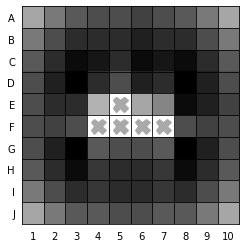

In [19]:
board.set_probabilities(superposition(probabilities))
print(superposition(probabilities))
board.get_figure(pdf=True)